# ConvLSTM

Import the required libraries

In [12]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as datetime
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split

Import tensorflow and check for GPU support

In [13]:
import tensorflow as tf
# Print num of GPUs if available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Set a seed to reproduce the results

In [14]:
seed_constant = 123
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Set data directories and other constants for the model

In [15]:
# Data paths are defined here
DATA_DIR = 'data'
VIDEO_PATH = os.path.join(DATA_DIR, 'videos')
ANNOTATION_PATH = os.path.join(DATA_DIR, 'annotations')
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation')

In [16]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Set a minimum duration in seconds to extract sequence in multiples of
MIN_DURATION = 150

(DIMENSION_X, DIMENSION_Y, DIMENSION_C) = (224, 224, 3)

In [17]:
class_mapping = {
'_cut___chop___slice_a_vegetable,_fruit,_or_meat_' : 'cut vegetables, herbs or meat',
'browse_through_clothing_items_on_rack___shelf___hanger' : 'browse through clothing items',
'clean___wipe_other_surface_or_object' : 'clean surface',
'dig_or_till_the_soil_with_a_hoe_or_other_tool' : 'till soil with a hoe',
'read_a_book___magazine___shopping_list_etc' : 'read a book',
'throw_away_trash___put_trash_in_trash_can' : 'throw away trash',
'wash_dishes___utensils___bakeware_etc' : 'wash utensils'}

Show some stills from training dataset

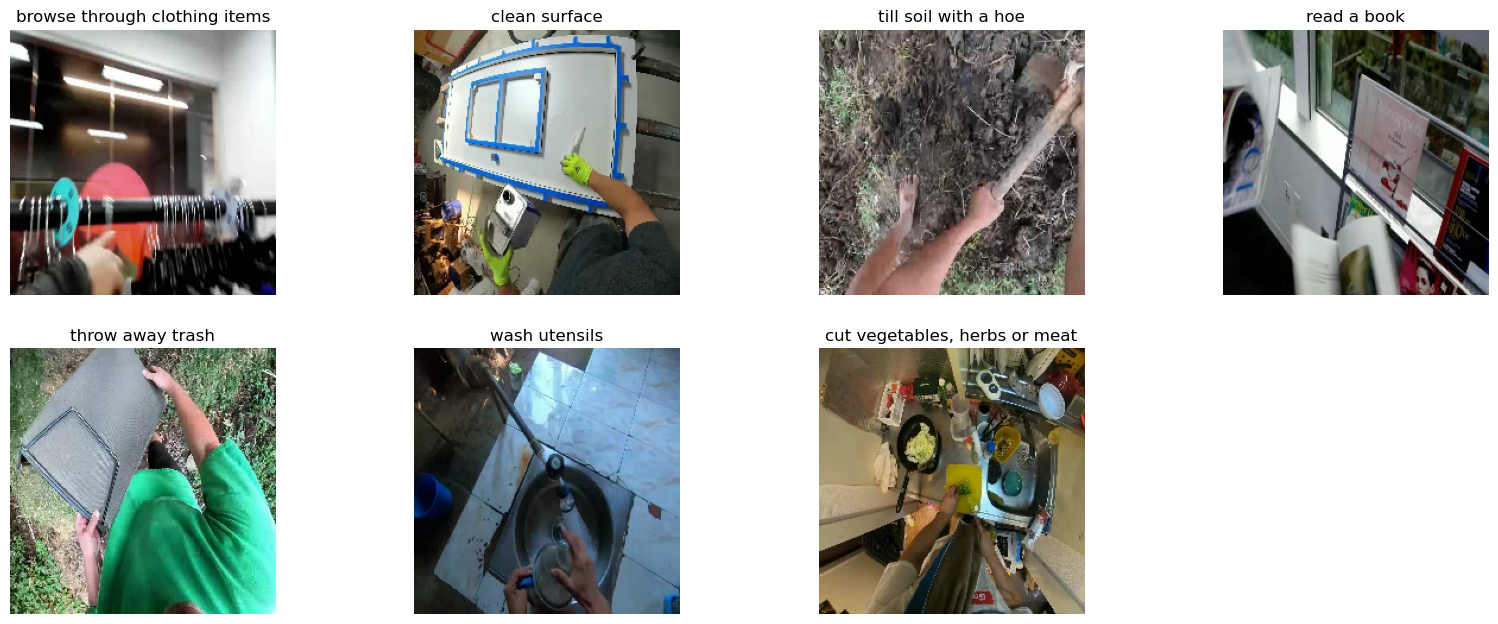

In [18]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in our dataset.
CLASSES_LIST = os.listdir(TRAINING_PATH)

# Iterating through all the classes.
for class_name in CLASSES_LIST:
    if class_name.startswith('.'): continue
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(os.path.join(TRAINING_PATH, class_name))

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    while not selected_video_file_name.endswith('.mp4'): selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(os.path.join(TRAINING_PATH, class_name, selected_video_file_name))
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Display the frame.
    plt.subplot(5, 4, CLASSES_LIST.index(class_name) + 1).set_title(class_mapping[class_name])
    plt.imshow(rgb_frame)
    plt.axis('off')

## Prepare the dataset

### Dataset generator

Get a list of all videos from training, validation and test dataset for data generator - read as video in data generator

In [8]:
def get_videos_and_labels_in_partition(partition_path):
	video_paths = []
	labels = {}
	for class_name in os.listdir(partition_path):
		if class_name not in CLASSES_LIST:
			print(f'{class_name} not found in class list!')
			continue
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.mp4'): continue
			video_path = os.path.join(partition_path, class_name, video_file_name)
			video_paths.append(video_path)
			labels[video_path] = CLASSES_LIST.index(class_name)
	return video_paths, labels

In [9]:
partition = {}
labels = {}
partition['train'], labels['train'] = get_videos_and_labels_in_partition(TRAINING_PATH)
partition['test'], labels['test'] = get_videos_and_labels_in_partition(TESTING_PATH)
partition['validation'], labels['validation'] = get_videos_and_labels_in_partition(VALIDATION_PATH)

In [10]:
print('Number of training videos: ', len(partition['train']))
print('Number of testing videos: ', len(partition['test']))
print('Number of validation videos: ', len(partition['validation']))

Number of training videos:  817
Number of testing videos:  186
Number of validation videos:  173


Create the data generator and define parameters for training and validation data generators

In [19]:
from batch_data_generator import DataGenerator

In [12]:
train_data_generator_params = {
	'load_video': True,
	'batch_size' : 80,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'load_video': True,
	'batch_size' : 20,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

In [13]:
training_generator = DataGenerator(partition['train'], labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(partition['validation'], labels['validation'], **validation_data_generator_params)

To randomly use only a part of the dataset, use the following code instead

In [ ]:
part_to_use = 0.5

train_partition = np.random.choice(partition['train'], int(len(partition['train']) * part_to_use), replace = False)
val_partition = np.random.choice(partition['validation'], int(len(partition['validation']) * part_to_use), replace = False)

training_generator = DataGenerator(train_partition, labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(val_partition, labels['validation'], **validation_data_generator_params)

### Read all videos, extract frams and save as nparrays 

In [20]:
from frames_extractor import video

In [21]:
def create_dataset_on_disk(data_path):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        if class_name.startswith('.'): continue
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name} from {data_path}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(data_path, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            if not file_name.endswith('.mp4'): continue
            # Get the complete video path.
            video_file_path = os.path.join(data_path, class_name, file_name)
            vid = video(video_file_path)
            # Extract the frames of the video file.
            frames = vid.frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) % SEQUENCE_LENGTH == 0:
                # Append the data to their repective lists.
                for i in range(0, len(frames), SEQUENCE_LENGTH):
                    np.save(os.path.join(data_path, class_name, 
                        f'{file_name[:-4]}_{i}.npy'), 
                        np.asarray(frames[i:i+SEQUENCE_LENGTH]))

In [22]:
%%time
create_dataset_on_disk(TRAINING_PATH)

Extracting Data of Class: browse_through_clothing_items_on_rack___shelf___hanger from data\videos\training


In [ ]:
%%time
create_dataset_on_disk(TESTING_PATH)

In [ ]:
%%time
create_dataset_on_disk(VALIDATION_PATH)

In [ ]:
def get_nparray_and_labels_in_partition(partition_path):
	nparrayfile_paths = []
	labels = {}
	for class_name in os.listdir(partition_path):
		if class_name not in CLASSES_LIST:
			print(f'{class_name} not found in class list!')
			continue
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.npy'): continue
			nparrayfile_path = os.path.join(partition_path, class_name, video_file_name)
			nparrayfile_paths.append(nparrayfile_path)
			labels[nparrayfile_path] = CLASSES_LIST.index(class_name)
	return nparrayfile_paths, labels

In [ ]:
nparray_partition = {}
nparray_labels = {}
nparray_partition['train'], nparray_labels['train'] = get_nparray_and_labels_in_partition(TRAINING_PATH)
nparray_partition['test'], nparray_labels['test'] = get_nparray_and_labels_in_partition(TESTING_PATH)
nparray_partition['validation'], nparray_labels['validation'] = get_nparray_and_labels_in_partition(VALIDATION_PATH)

In [ ]:
train_data_generator_params = {
	'batch_size' : 80,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'batch_size' : 20,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

In [ ]:
training_generator = DataGenerator(nparray_partition['train'], nparray_labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(nparray_partition['validation'], nparray_labels['validation'], **validation_data_generator_params)

## Create model - ConvLSTM

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## TO-DO:

- Explore different params to finetune model

In [15]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      DIMENSION_X, DIMENSION_Y, DIMENSION_C)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [16]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 4)  0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 111, 111, 4)  0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 55, 55, 8)    0         
 3D)                                                             
                                                        

Compile and train the model

In [ ]:
%%time
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=6, 
    epochs = 50,
    callbacks = [early_stopping_callback])

Evaluate the model on test dataset

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(x = validation_generator, use_multiprocessing=True, workers=6)